In [22]:
import os
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import pandas as pd
import numpy as np
from src.utils.data_utils import get_related_videos_with_keywords
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff

In [23]:
DATA_PATH = "./data"

In this notebook, we start with cleaning and comprehensive exploration of the dataset in Part 0 to ensure a thorough understanding of its structure and content. In the following sections, we conduct some basis analyses to assess the feasibility of our proposed methods. We will delve deeper into these analyses in Milestone 3.

# Part 0: Get to know the dataset

In the YouNiverse dataset, we are given 4 main types of data:
- Video data
- Channel data 
- Timeseries data about the increasing number of subscribers, videos and views of channels
- Comment data 

We will explore each data seperately and then combine them to get some insights.

## Load original dataset

Load original dataset

In [4]:
# Load channel dataset
df_ch_f = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])

In [5]:
# Load timeseries dataset
df_ts_f = pd.read_csv(os.path.join(DATA_PATH, "df_timeseries_en.tsv.gz"), compression="infer", sep="\t")
df_ts_f["datetime"] = pd.to_datetime(df_ts_f["datetime"])

In [6]:
# Load video dataset without descriptions and tags
df_vd_f = pd.read_feather(os.path.join(DATA_PATH, "yt_metadata_helper.feather"))

## Video data

In [14]:
# Examine NaN values
print("Number of NaN values in each column:")
print(df_vd_f.isnull().sum())

Number of NaN values in each column:
categories             0
channel_id             0
dislike_count    1631458
display_id             0
duration               0
like_count       1631458
upload_date            0
view_count           654
dtype: int64


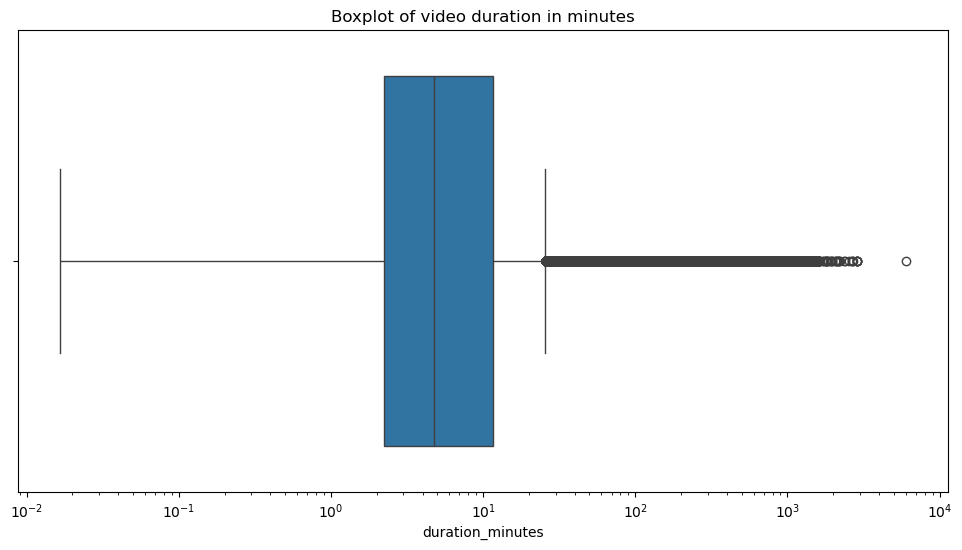

In [65]:
# Boxplot of video duration
df_vd_f["duration_minutes"] = df_vd_f["duration"].apply(lambda x: x/60)

plt.figure(figsize=(12, 6))
sns.boxplot(x="duration_minutes", data=df_vd_f)
plt.title("Boxplot of video duration in minutes")
plt.xscale("log")
plt.show()

## Channel data

In [6]:
df_ch_f.head(10)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087
5,Entertainment,2007-01-15,UCIwFjwMjI0y7PDBVEO9-bkQ,Justin Bieber,46574085,134,12.0,2.087
6,Music,2014-03-12,UCFFbwnve3yF62-tVXkTyHqg,Zee Music Company,43451109,4241,13.0,2.087
7,Sports,2009-03-17,UCRijo3ddMTht_IHyNSNXpNQ,Dude Perfect,45800000,213,14.0,2.087
8,Entertainment,2015-05-12,UCk8GzjMOrta8yxDcKfylJYw,✿ Kids Diana Show,34700000,599,16.0,2.087
9,Music,2006-08-08,UC0C-w0YjGpqDXGB8IHb662A,Ed Sheeran,42000000,154,17.0,2.087


In [78]:
# Examine NaN values
print("Number of NaN values in each column:")
print(df_ch_f.isnull().sum())

Number of NaN values in each column:
category_cc           128
join_date               1
channel                 0
name_cc                10
subscribers_cc          0
videos_cc               0
subscriber_rank_sb      0
weights                 0
dtype: int64


In [79]:
# Check channel with join_date NaN
df_ch_f[df_ch_f["join_date"].isnull()]

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
62,Entertainment,NaT,UCBR8-60-B28hp2BmDPdntcQ,YouTube,28200000,301,110.0,2.087


In [48]:
# Remove channel with join_date NaN
df_ch_f = df_ch_f.dropna(subset=["join_date"])

In [81]:
print("Number of channels collected: ", df_ch_f.shape[0])

Number of channels collected:  136469


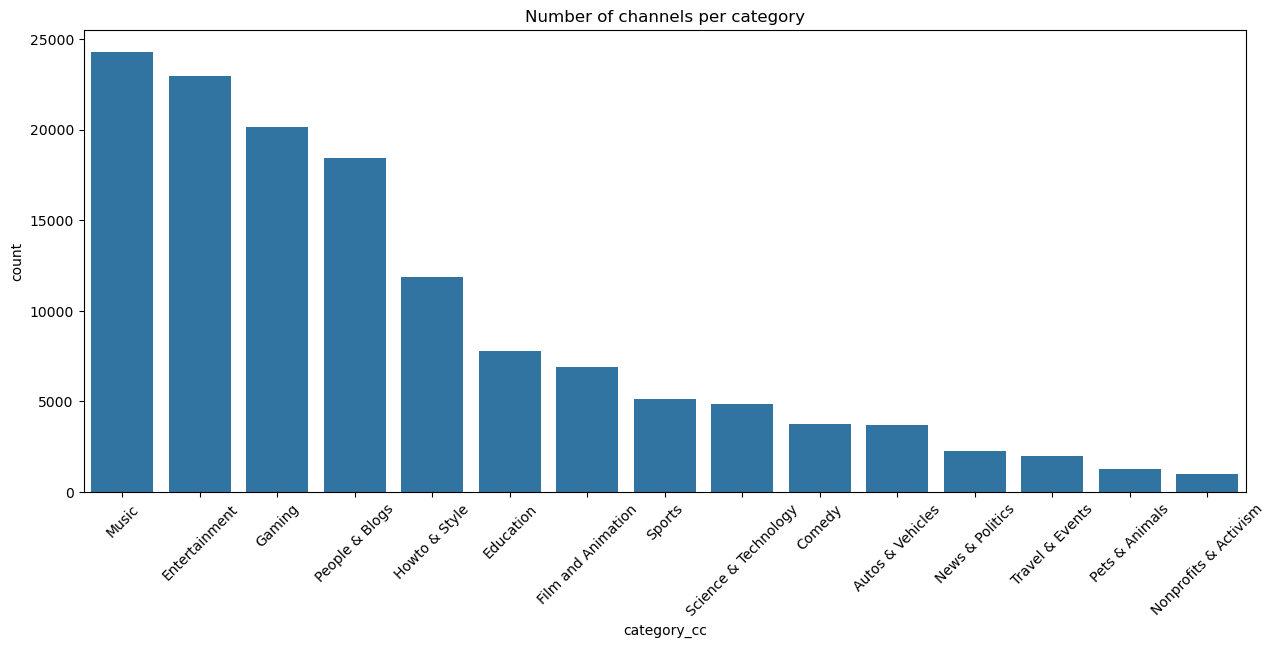

category_cc
Music                    24285
Entertainment            22950
Gaming                   20143
People & Blogs           18413
Howto & Style            11875
Education                 7803
Film and Animation        6875
Sports                    5148
Science & Technology      4864
Comedy                    3767
Autos & Vehicles          3705
News & Politics           2263
Travel & Events           1989
Pets & Animals            1292
Nonprofits & Activism      969
Name: count, dtype: int64

In [82]:
# Plot the number of channels per category
plt.figure(figsize=(15, 6))
sns.countplot(x="category_cc", data=df_ch_f, order=df_ch_f.category_cc.value_counts().index)
plt.xticks(rotation=45)
plt.title("Number of channels per category")
plt.show()
df_ch_f.category_cc.value_counts()

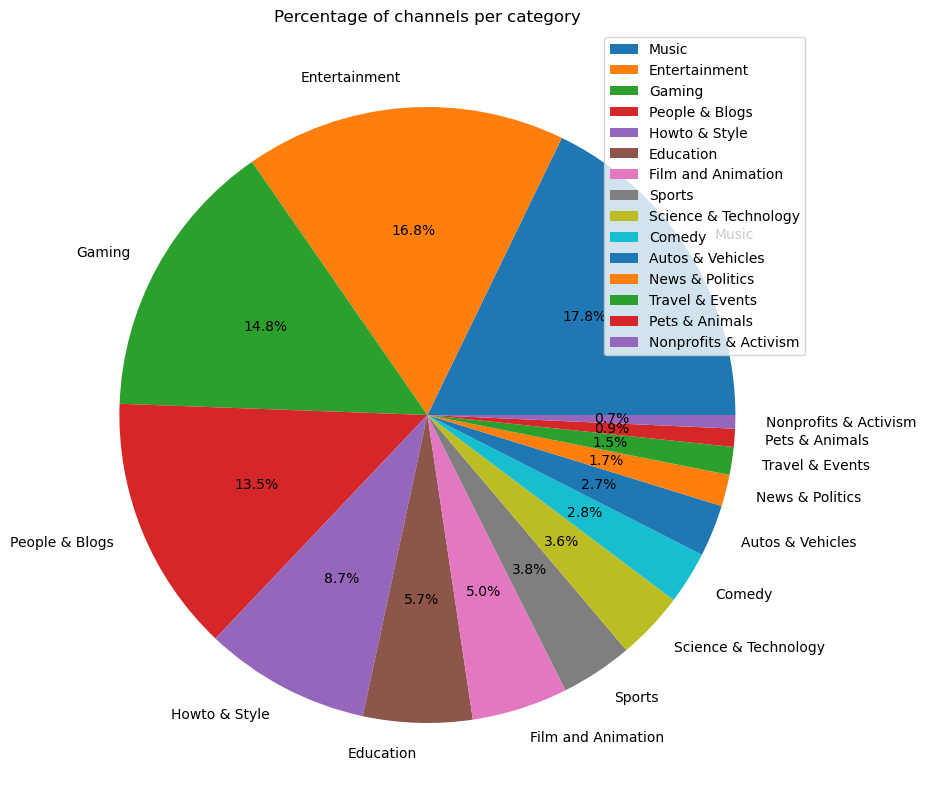

In [83]:
# Plot pie chart percentage of channels per category
plt.figure(figsize=(10, 10))
df_ch_f.category_cc.value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Percentage of channels per category")
plt.ylabel("")
plt.legend()
plt.show()

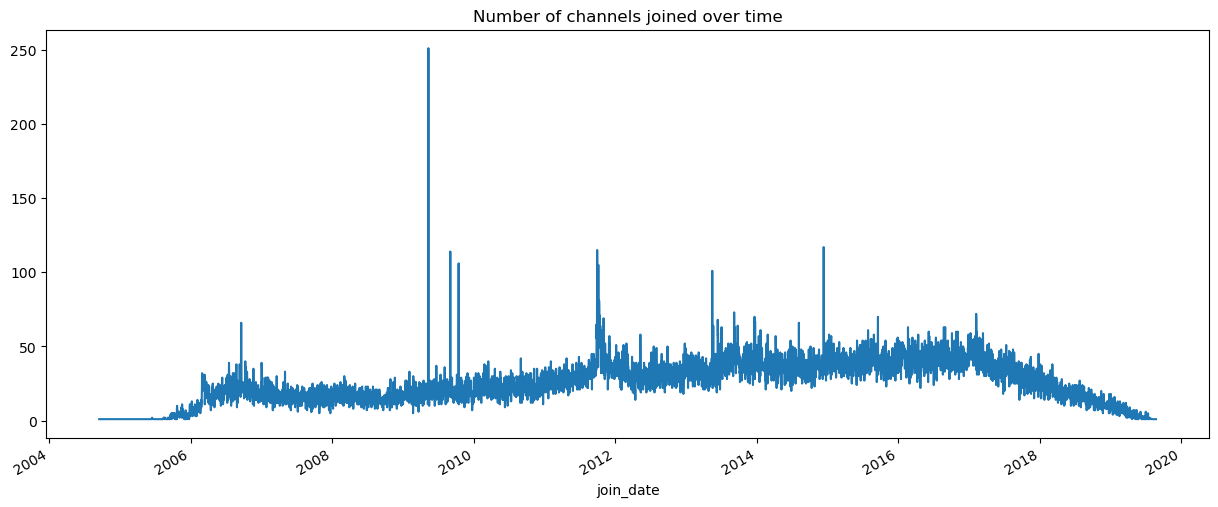

In [84]:
# Number of channels joined over time line plot
plt.figure(figsize=(15, 6))
df_ch_f["join_date"].value_counts().sort_index().plot()
plt.title("Number of channels joined over time")
plt.show()

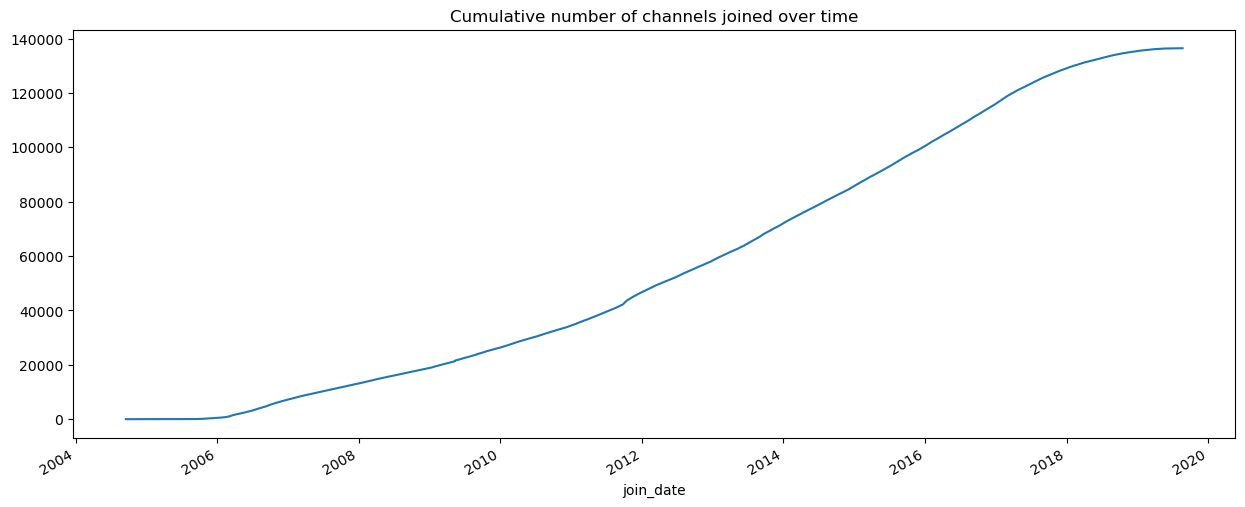

In [95]:
# Culmulative number of channels joined over time
cumulative_counts = df_ch_f["join_date"].value_counts().sort_index().cumsum()

plt.figure(figsize=(15, 6))
cumulative_counts.plot()
plt.title("Cumulative number of channels joined over time")
plt.show()

<Figure size 1500x600 with 0 Axes>

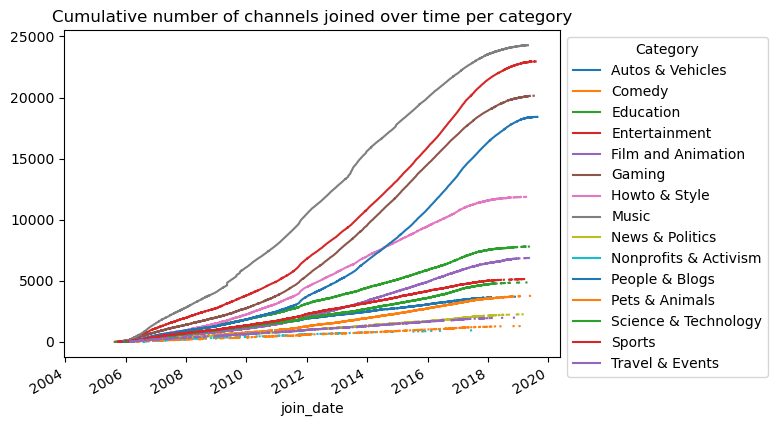

In [94]:
# Culumative number of channels joined over time per category
plt.figure(figsize=(15, 6))
df_ch_f.groupby(["join_date", "category_cc"]).size().unstack().cumsum().plot()
plt.title("Cumulative number of channels joined over time per category")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()

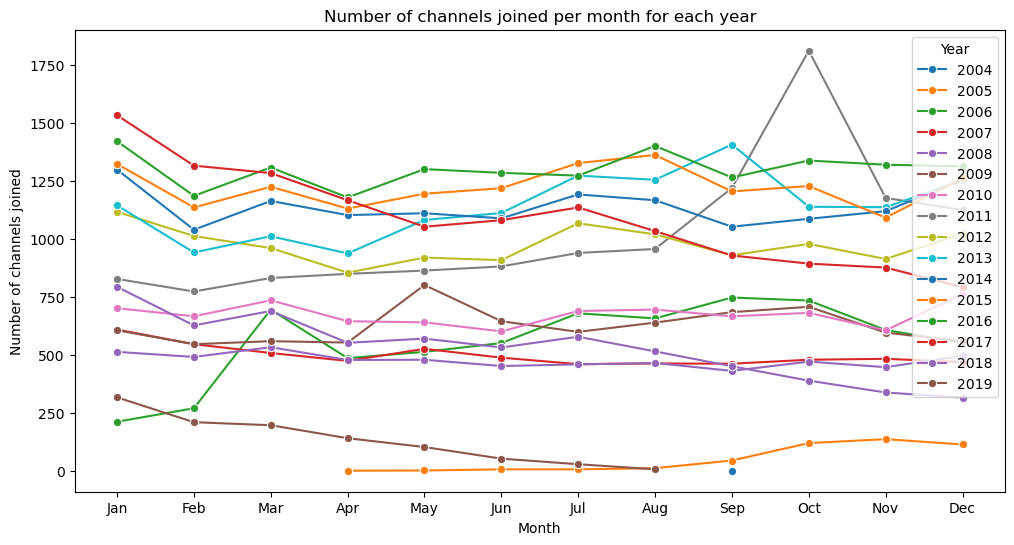

In [89]:
# Number of channels joined per month for each year
df_ch_f["year"] = df_ch_f["join_date"].dt.year.astype(int)
df_ch_f["month"] = df_ch_f["join_date"].dt.month

monthly_counts = df_ch_f.groupby(["year", "month"]).size().reset_index(name="channel_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="month", y="channel_count", hue="year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of channels joined")
plt.title("Number of channels joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

<Figure size 1500x600 with 0 Axes>

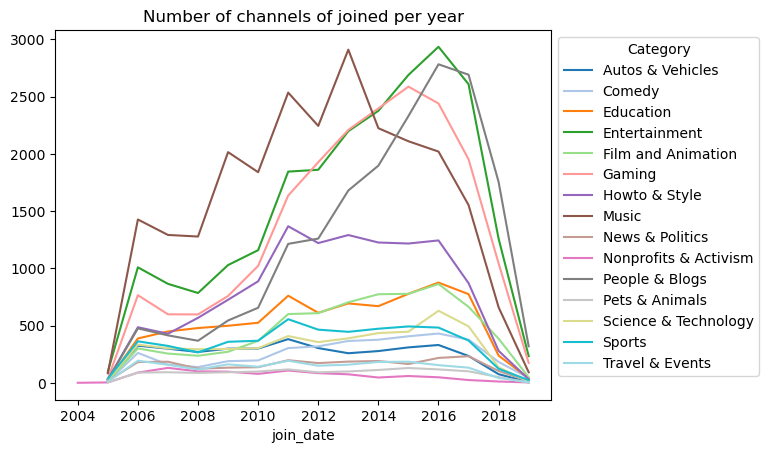

In [39]:
# Number of channels of different categories joined per year
plt.figure(figsize=(15, 6))
df_ch_f.groupby([df_ch_f["join_date"].dt.year, "category_cc"]).size().unstack().plot(colormap="tab20")
plt.title("Number of channels of joined per year")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()

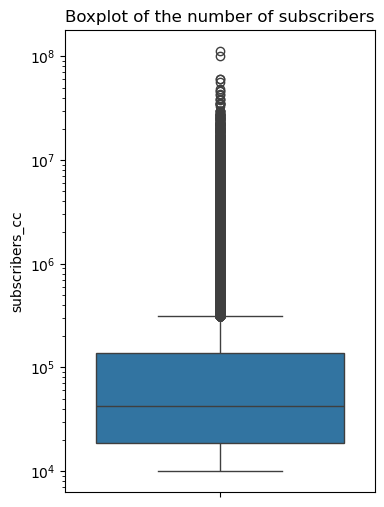

In [57]:
# Boxplot of the number of subscribers
plt.figure(figsize=(4, 6))
sns.boxplot(y="subscribers_cc", data=df_ch_f)
plt.title("Boxplot of the number of subscribers")
plt.yscale("log")
plt.show()


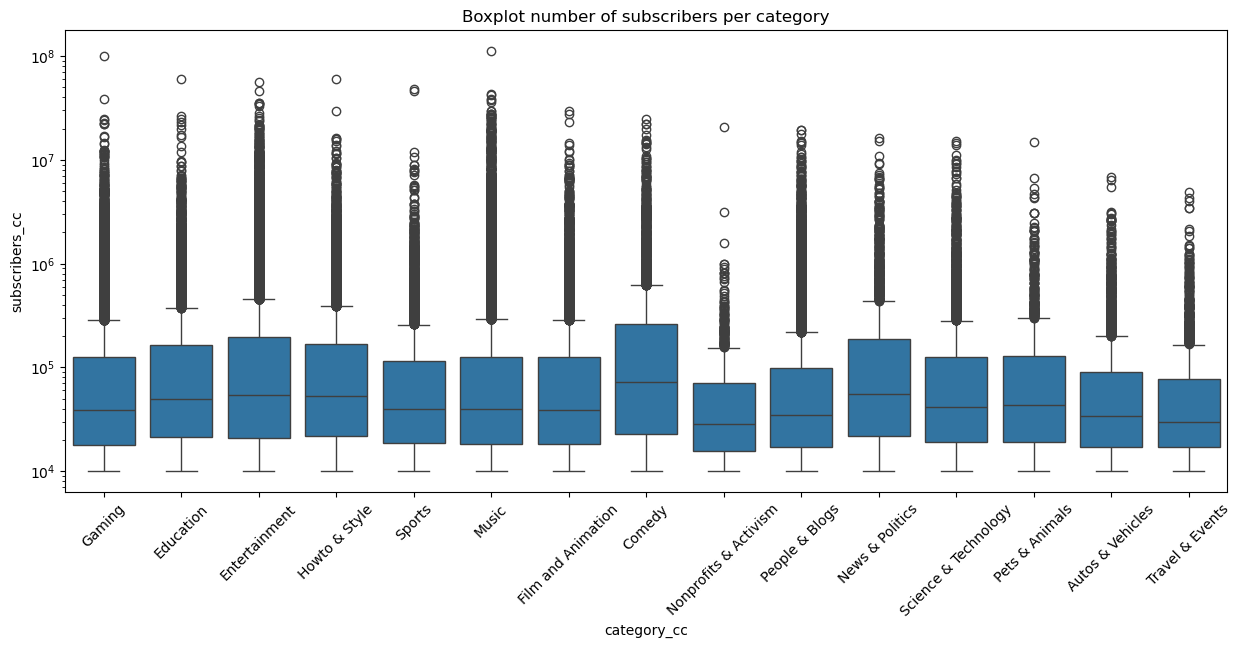

In [59]:
# Boxplot of the number of subscribers per category
plt.figure(figsize=(15, 6))
sns.boxplot(x="category_cc", y="subscribers_cc", data=df_ch_f)
plt.xticks(rotation=45)
plt.title("Boxplot number of subscribers per category")
plt.yscale("log")
plt.show()

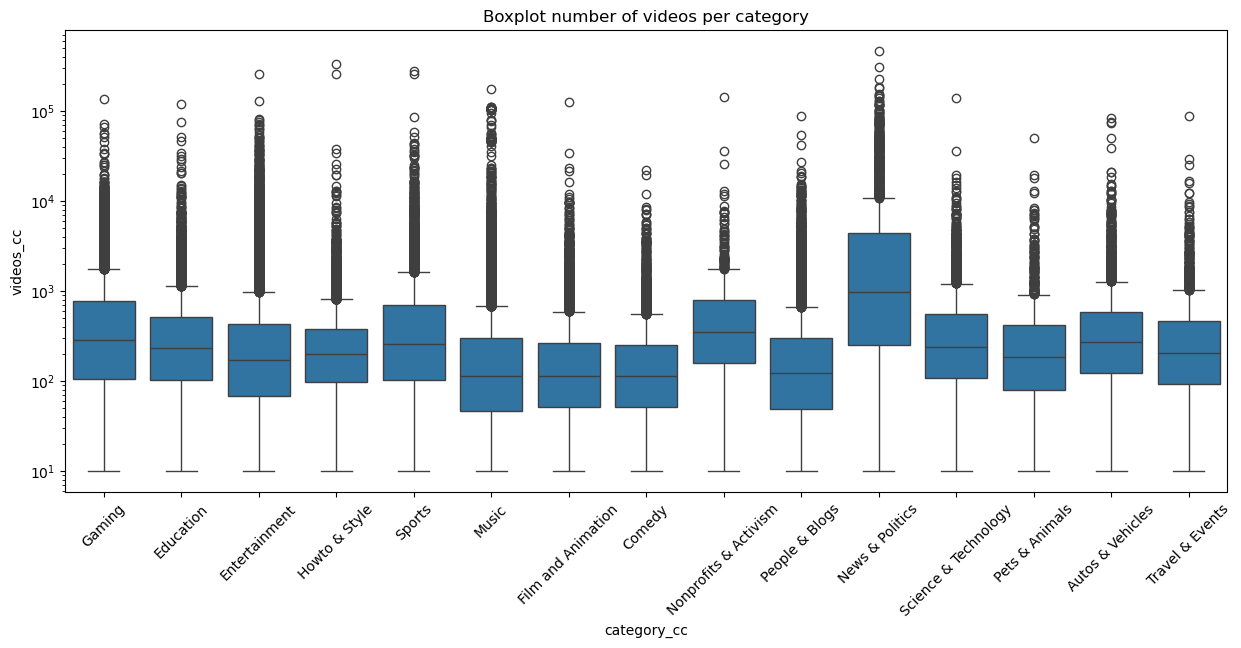

In [61]:
# Boxplot of the number of videos per category
plt.figure(figsize=(15, 6))
sns.boxplot(x="category_cc", y="videos_cc", data=df_ch_f)
plt.xticks(rotation=45)
plt.title("Boxplot number of videos per category")
plt.yscale("log")
plt.show()

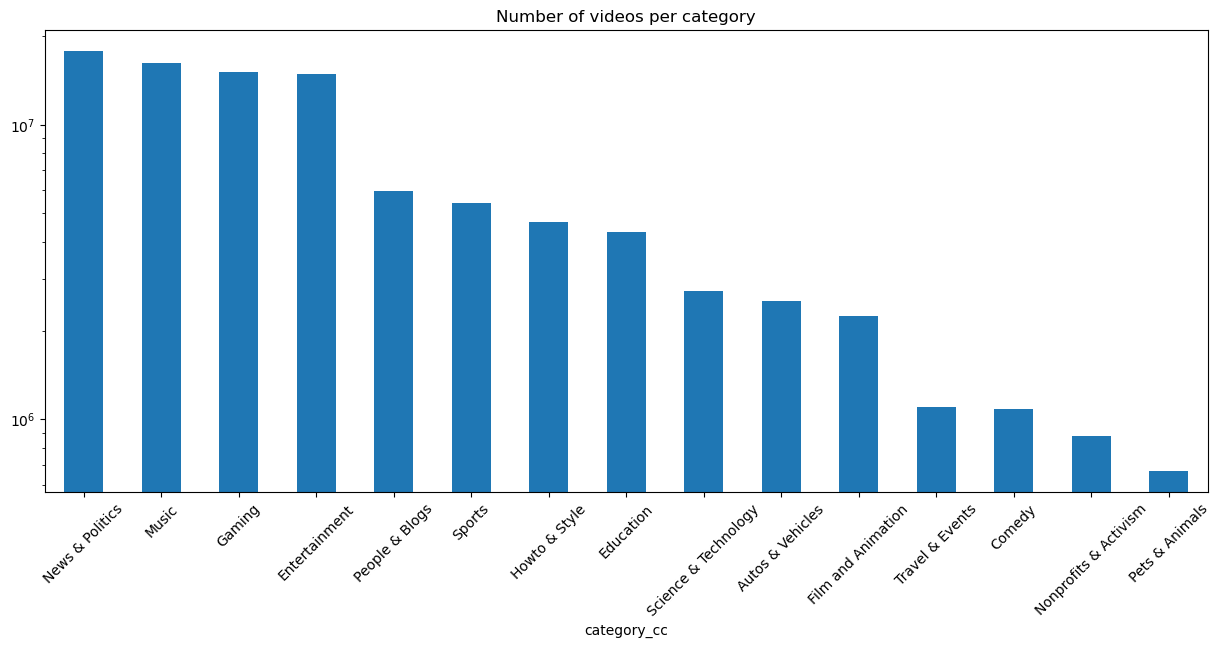

In [64]:
# Total number of videos per category in descending order
plt.figure(figsize=(15, 6))
df_ch_f.groupby("category_cc")["videos_cc"].sum().sort_values(ascending=False).plot(kind="bar")
plt.xticks(rotation=45)
plt.yscale("log")
plt.title("Number of videos per category")
plt.show()

## Timeseries data

In [20]:
df_ts_f.head(5)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [24]:
# Examine NaN values
print("Number of NaN values in each column:")
print(df_ts_f.isnull().sum())

Number of NaN values in each column:
channel             0
category        20584
datetime            0
views               0
delta_views         0
subs                0
delta_subs          0
videos              0
delta_videos        0
activity            0
dtype: int64


In [16]:
# Check timeseries period
print("Start date: ", df_ts_f["datetime"].min())
print("End date: ", df_ts_f["datetime"].max())

Start date:  2015-01-05 00:00:00
End date:  2019-09-30 01:00:00


In [72]:
df_ts_f["channel"].nunique()

133516

In [85]:
# Number of missing channels in timeseries dataset
n_missing_channels = df_ch_f["channel"].nunique() - df_ts_f["channel"].nunique()
print("Total number of channels in channel dataset: ", df_ch_f.shape[0])
print(f"Number of missing channels in timeseries dataset: {n_missing_channels} accounted for {n_missing_channels / df_ch_f.shape[0] * 100:.2f}% of the total channels")

n_missing_sports_channels = df_ch_f[df_ch_f["category_cc"] == "Sports"]["channel"].nunique() - df_ts_f[df_ts_f["category"] == "Sports"]["channel"].nunique()
print(f"Number of missing sports channels in timeseries dataset: {n_missing_sports_channels} accounted for {n_missing_sports_channels / df_ch_f[df_ch_f['category_cc'] == 'Sports'].shape[0] * 100:.2f}% of the total sports channels")

Total number of channels in channel dataset:  136469
Number of missing channels in timeseries dataset: 2953 accounted for 2.16% of the total channels
Number of missing sports channels in timeseries dataset: 128 accounted for 2.49% of the total sports channels


In [81]:
# Sort data in increasing order of datetime
df_ts_f = df_ts_f.sort_values("datetime")

In [84]:
# Check if the datetime period between 2 consecutive collected data of each channel is 7 days
df_ts_f["time_diff"] = df_ts_f.groupby("channel")["datetime"].diff()
df_ts_f["time_diff"].value_counts()

time_diff
7 days 00:00:00    18068328
7 days 01:00:00      351204
6 days 23:00:00      319451
Name: count, dtype: int64

# Part 1: General sports-related analysis

### Sports channels

In [7]:
df_ch_sports = df_ch_f[df_ch_f["category_cc"] == "Sports"]

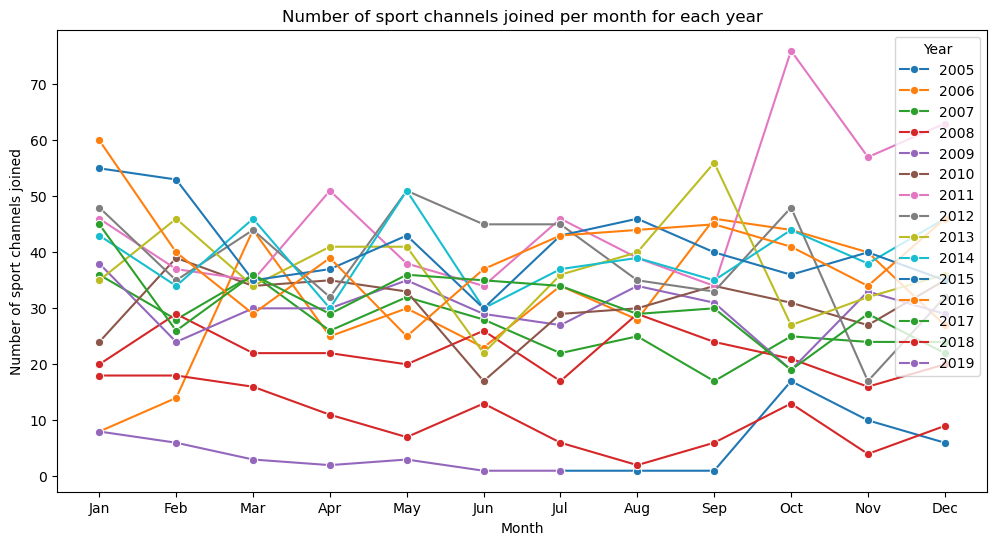

In [63]:
# Number of channels joined per month for each year
df_ch_sports_copy = df_ch_sports.copy()
df_ch_sports_copy["join_year"] = df_ch_sports_copy["join_date"].dt.year.astype(int)
df_ch_sports_copy["join_month"] = df_ch_sports_copy["join_date"].dt.month
monthly_counts = df_ch_sports_copy.groupby(["join_year", "join_month"]).size().reset_index(name="channel_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="join_month", y="channel_count", hue="join_year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of sport channels joined")
plt.title("Number of sport channels joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [69]:
# Merge sports channels with timeseries dataset
df_ch_ts_sports = pd.merge(df_ts_f, df_ch_sports, on="channel", how="inner")

In [77]:
df_ch_ts_sports

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,join_year,join_month
0,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-08,2.649723e+06,6505.000000,3505.000000,0.000000,241,0,0,Sports,2010-03-15,MAGURA,11800,353,803733.0,12.0500,2010,3
1,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-15,2.661633e+06,11909.875000,3523.000000,18.000000,241,0,0,Sports,2010-03-15,MAGURA,11800,353,803733.0,12.0500,2010,3
2,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-22,2.674360e+06,12726.625000,3537.250000,14.250000,241,0,0,Sports,2010-03-15,MAGURA,11800,353,803733.0,12.0500,2010,3
3,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-02-29,2.687528e+06,13168.625000,3552.625000,15.375000,241,0,0,Sports,2010-03-15,MAGURA,11800,353,803733.0,12.0500,2010,3
4,UCNTpErdUqTDqWq7YG1nasOQ,Sports,2016-03-07,2.701620e+06,14091.875000,3571.000000,18.375000,241,0,0,Sports,2010-03-15,MAGURA,11800,353,803733.0,12.0500,2010,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762258,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-02,3.857756e+06,23270.000000,35128.833333,206.388889,11,0,0,Sports,2014-12-05,Alex Moyer,35400,11,368633.0,9.0075,2014,12
762259,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-09,3.870991e+06,13234.666667,35221.000000,92.166667,11,0,0,Sports,2014-12-05,Alex Moyer,35400,11,368633.0,9.0075,2014,12
762260,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-16,3.883723e+06,12732.100000,35310.000000,89.000000,11,0,0,Sports,2014-12-05,Alex Moyer,35400,11,368633.0,9.0075,2014,12
762261,UCLV-Fynzx2bc3WxF8-goCvA,Sports,2019-09-23,3.893440e+06,9716.700000,35380.000000,70.000000,11,0,0,Sports,2014-12-05,Alex Moyer,35400,11,368633.0,9.0075,2014,12


In [106]:
def plot_sum_delta_amount_overtime(df, delta_cols: list[str]):
    # Create a new column that combines year and month
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['year_month'] = df['year'].astype(
        str) + '-' + df['month'].astype(str).str.zfill(2)

    # Group by the new 'year_month' column and sum the "delta" counts
    year_month_view_count = df.groupby('year_month')[delta_cols].sum().reset_index()
    
    # print(year_month_view_count.head())

    # Plot the data
    plt.figure(figsize=(40, 12))
    for delta_col in delta_cols:
        plt.plot(year_month_view_count['year_month'],
                 year_month_view_count[delta_col], marker='o', label=delta_col)
    plt.title(f'Sum {delta_cols} over time')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

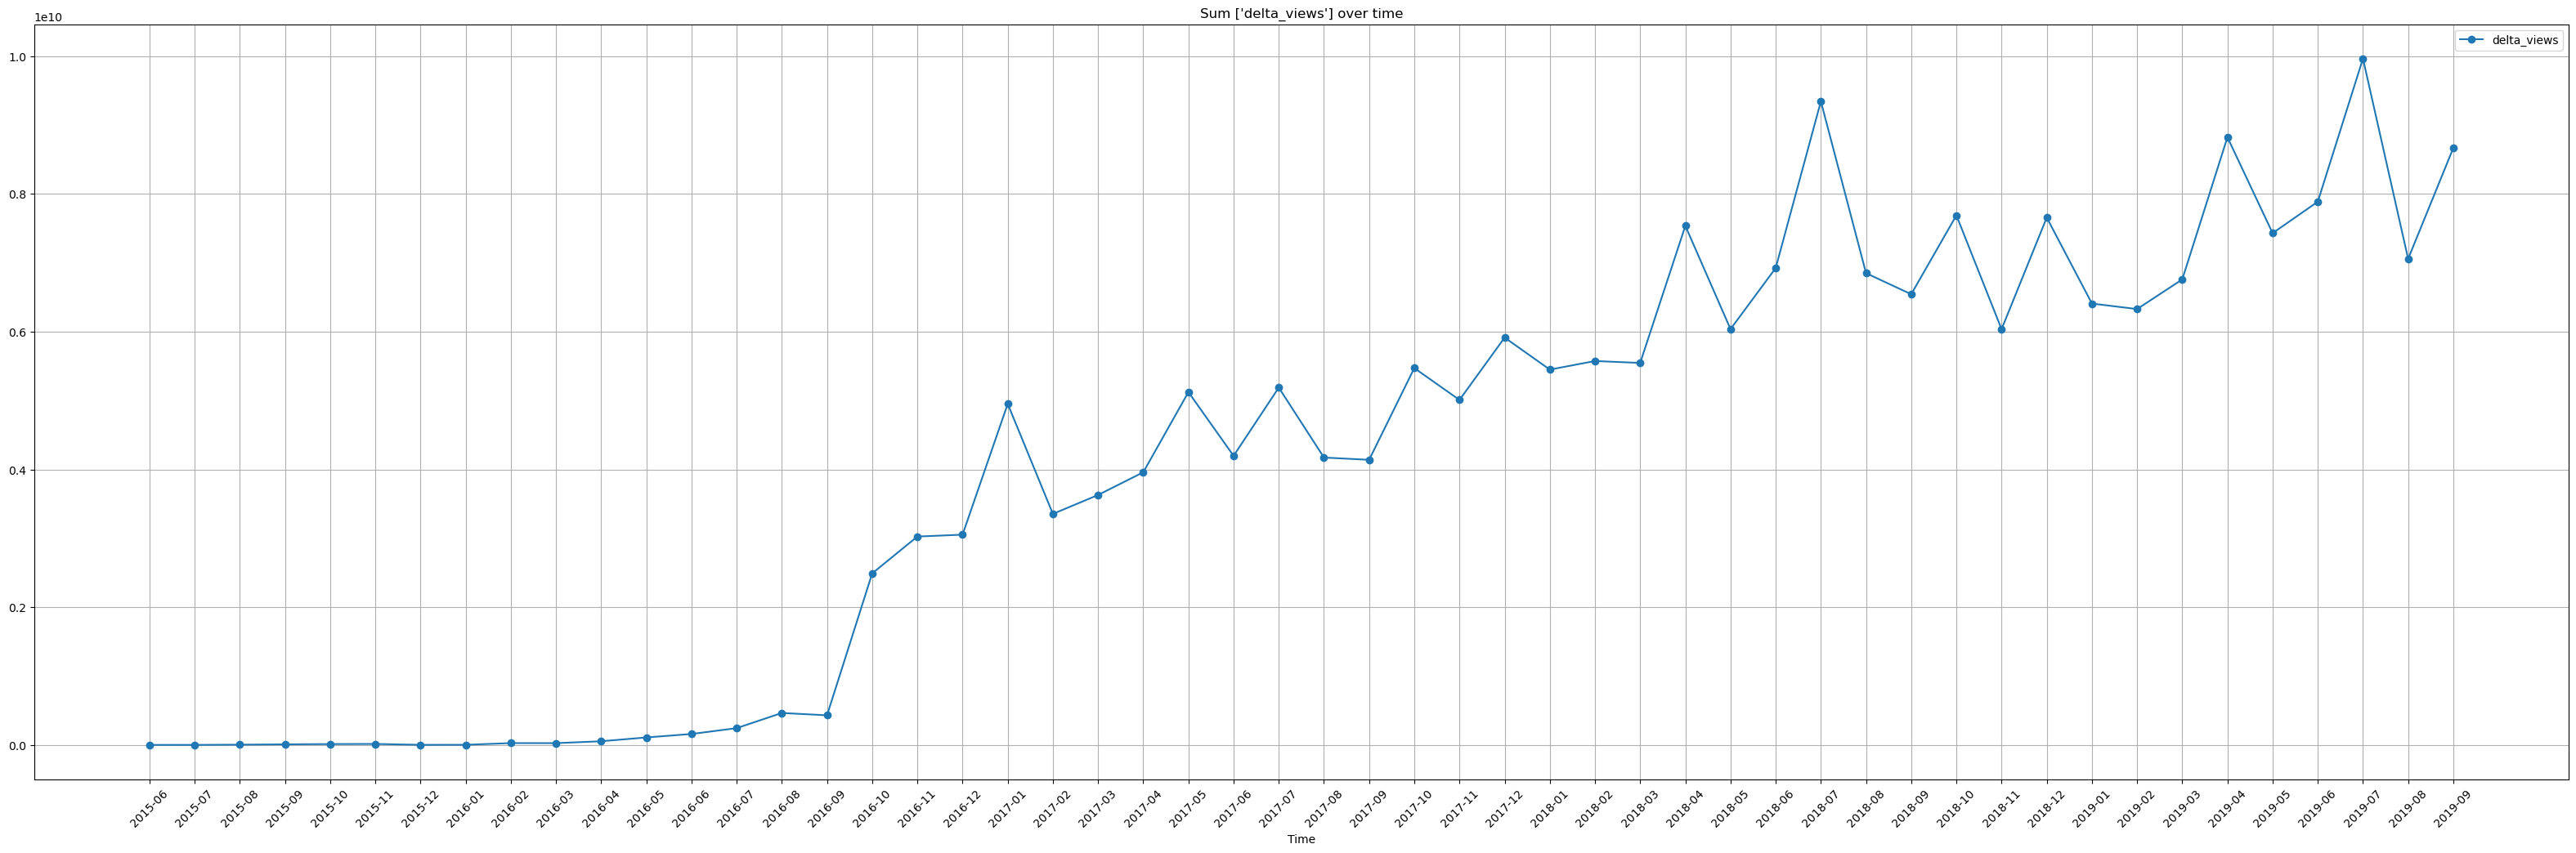

In [107]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_views"])

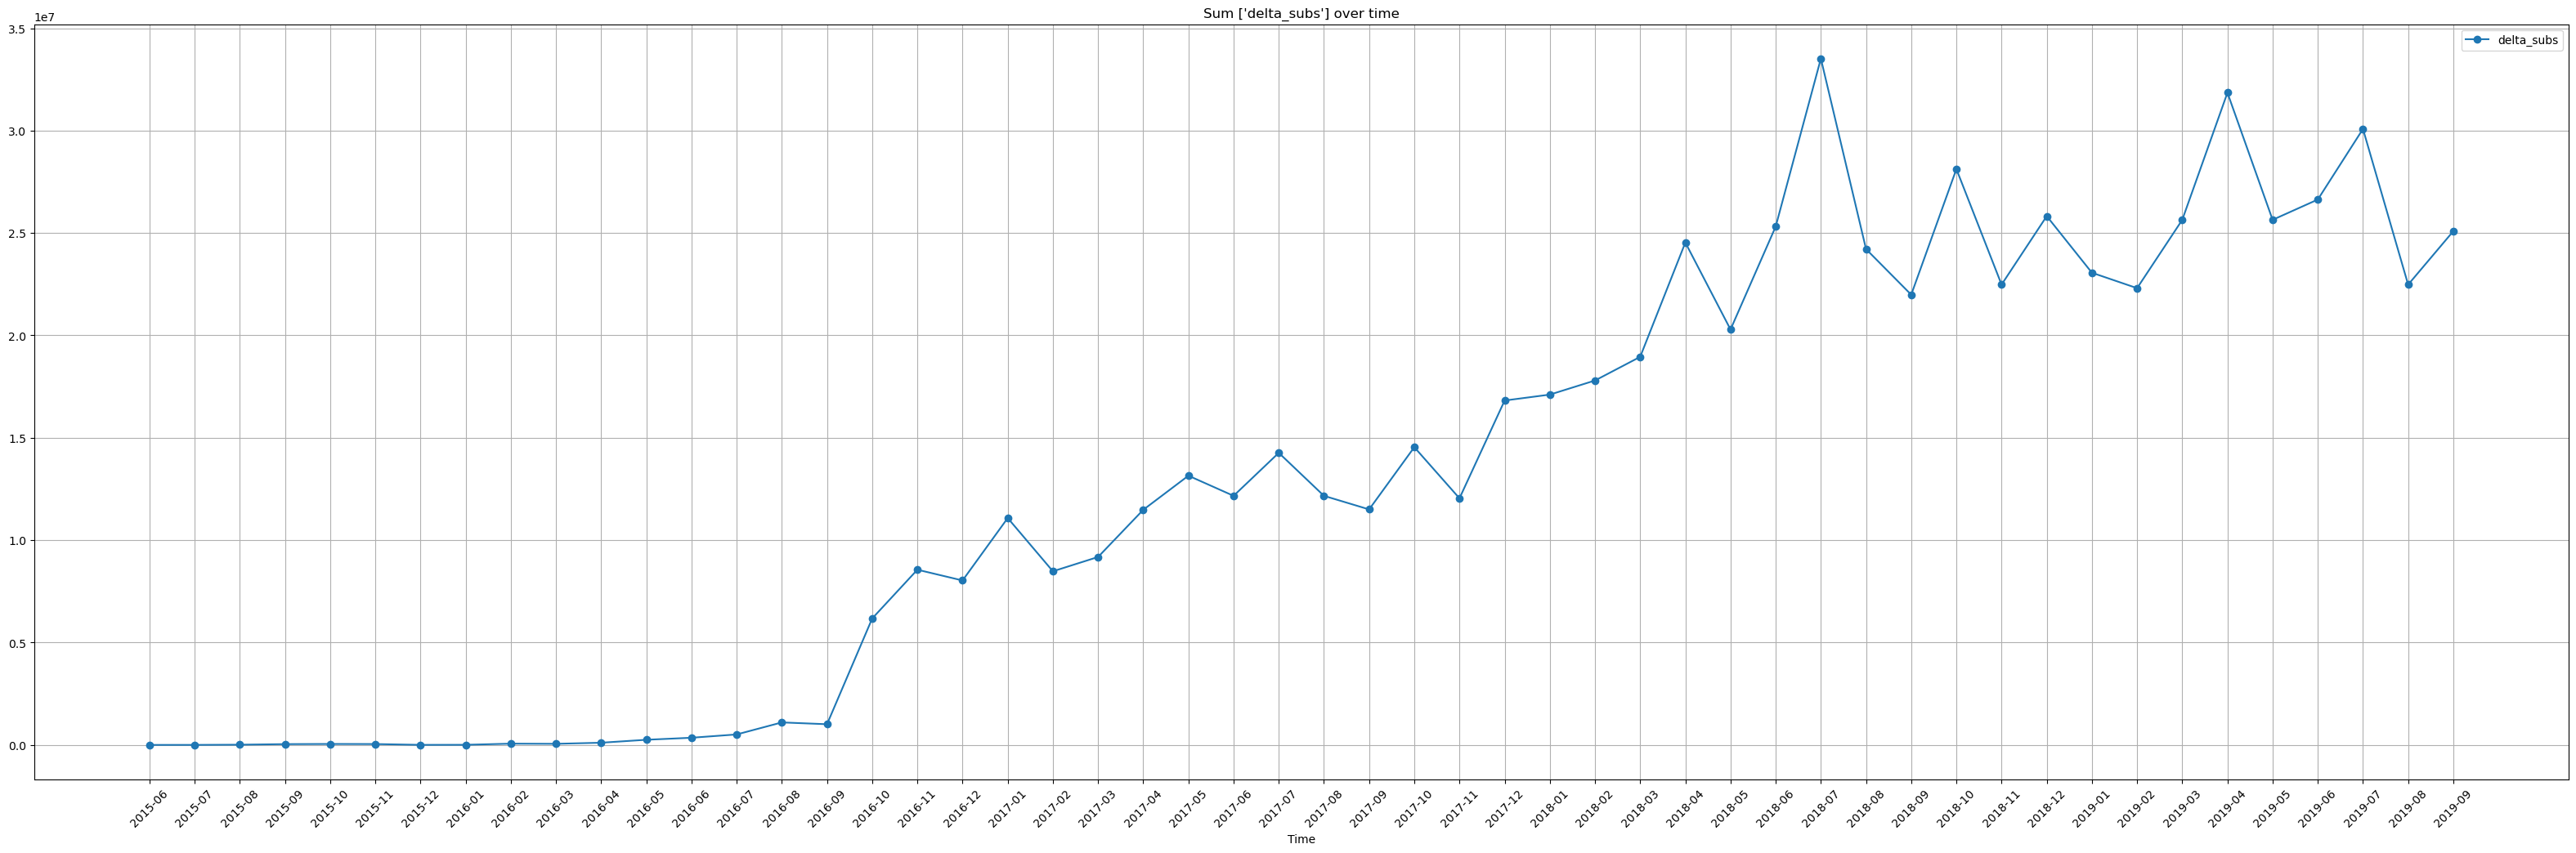

In [109]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_subs"])

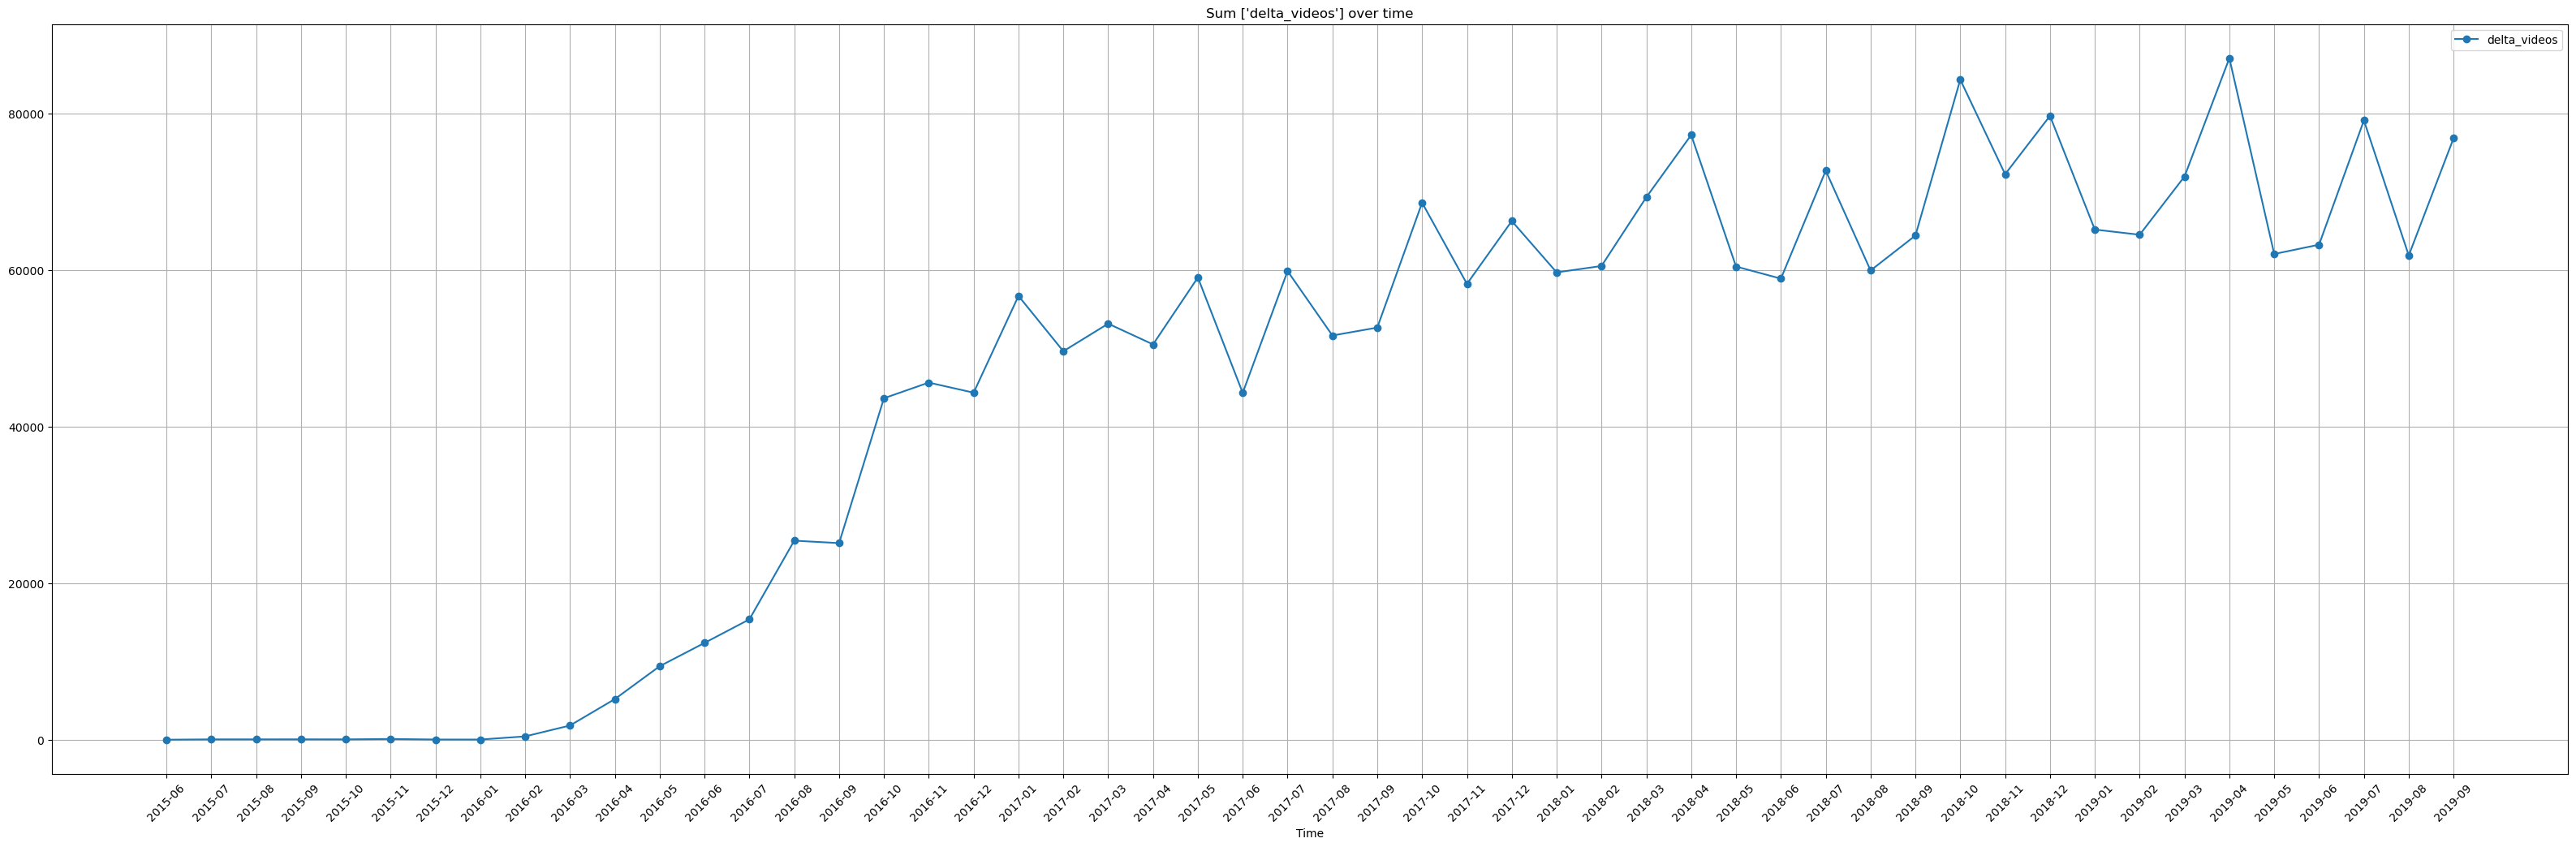

In [110]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_videos"])

In [115]:
# Plot X by month for each year
def plot_x_by_month_for_each_year(df, x_col: str, years=None):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    if years is not None:
        df = df[df['year'].isin(years)]
        
    data = df.groupby(['year', 'month'])[x_col].sum().reset_index()
    
    pivot_data = data.pivot(index='month', columns='year', values=x_col)
    
    pivot_data.plot(kind='line', figsize=(15, 8))
    plt.title(f'{x_col} by month for each year')
    plt.xlabel('Month')
    plt.ylabel(x_col)
    plt.xticks(range(1, 13), 
               ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.legend(title='Year')
    plt.show()
        

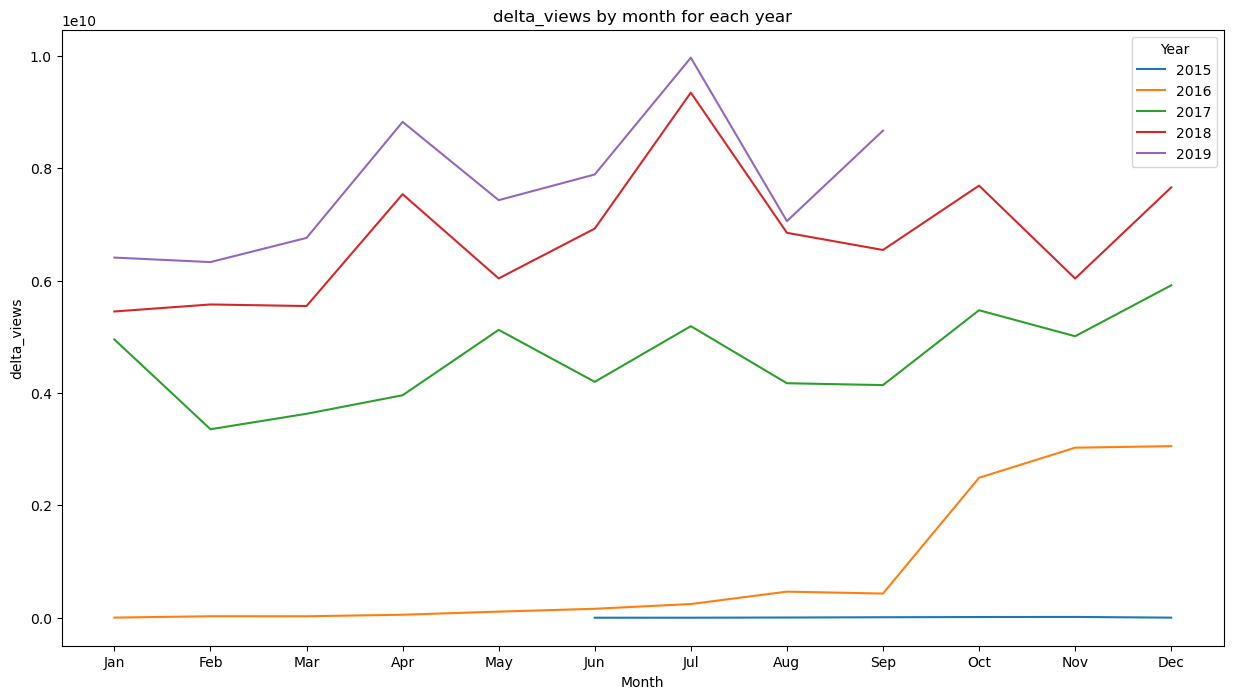

In [116]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_views')

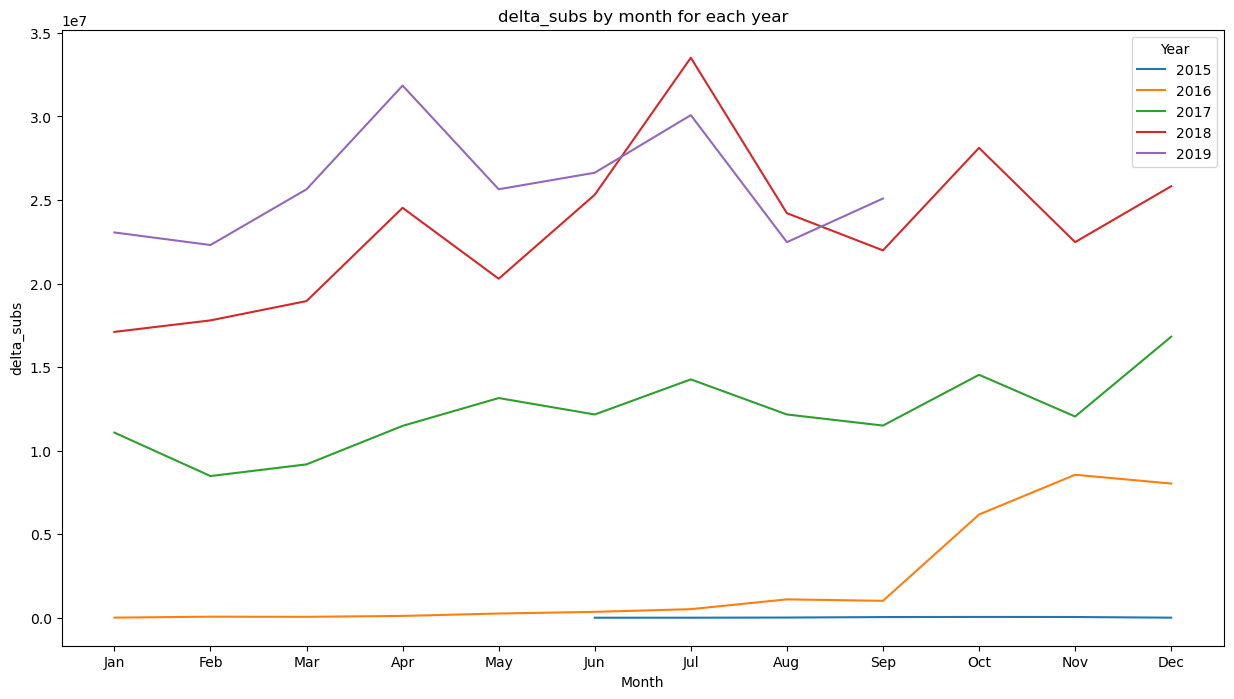

In [117]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_subs')

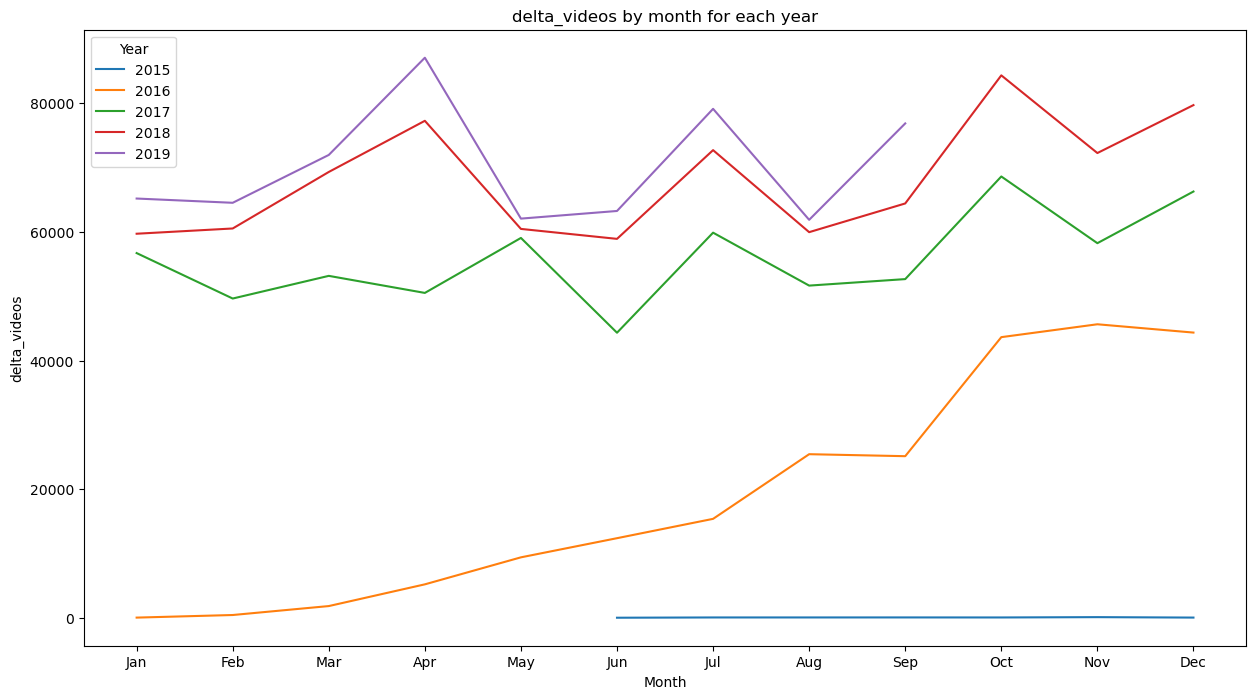

In [118]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_videos')

### Sports videos

In [11]:
# Note: this dataset is created using script in src/scripts/sport_videos.py
# Load sports category videos dataset (with descriptions and tags)
pq_sports = pq.ParquetFile(os.path.join(DATA_PATH, "yt_metadata_en_sport.parquet"))
df_vd_sports = pq_sports.read().to_pandas()

In [12]:
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"])

In [13]:
df_vd_sports.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
index,,,,,,,,,,,,
1292,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,Can I catch 100 lbs of catfish LIVE. Me and Ja...,35.0,JOeSxtcNdHQ,8620,1673.0,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0
1293,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,,15.0,EPMLTw2zINw,355,1297.0,,big cat,2019-10-01,19999.0
1294,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,Are you ready to enter the high fashion world ...,78.0,Y1_pK68iSYQ,603,3305.0,"Catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0
1295,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,Saltwater fishing out of Newquay Cornwall UK. ...,70.0,jF8TSo3ZfTc,1426,1889.0,"Fishing,Fishing uk,Angling,Sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0
1296,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,My family spent 3 weeks touring England and fi...,73.0,Gp00dNaVouo,990,2699.0,"Fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0


In [8]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [9]:
all_tags_sport = get_all_tags(df_vd_sports)

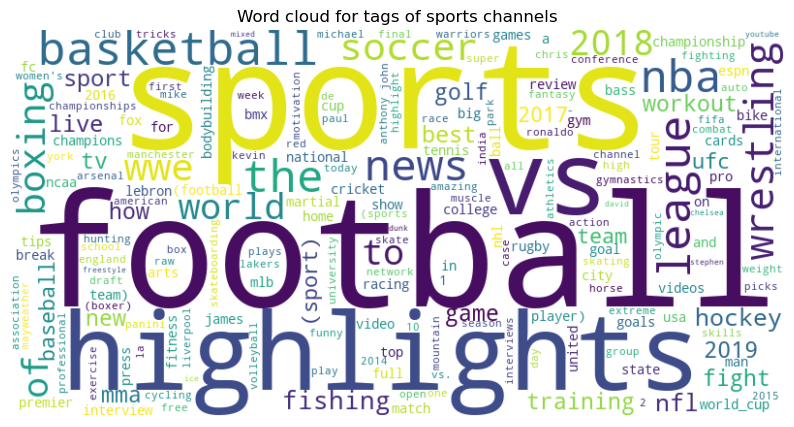

In [10]:
# Plot word cloud for tags of sports channels
plot_wordcloud(all_tags_sport, "Word cloud for tags of sports channels")

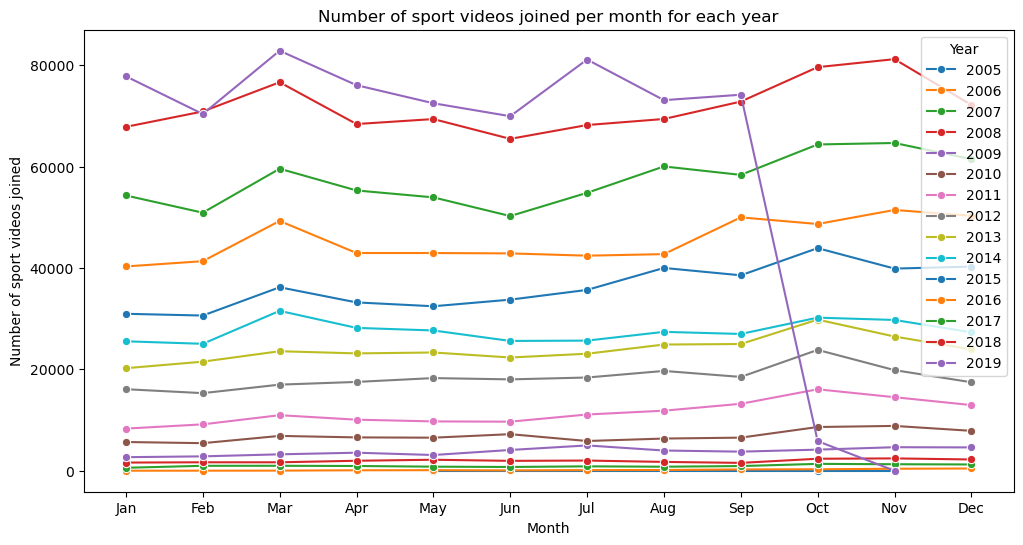

In [68]:
# Number of of sports videos uploaded per month for each year
df_vd_sports_copy = df_vd_sports.copy()
df_vd_sports_copy["year"] = df_vd_sports_copy["upload_date"].dt.year.astype(int)
df_vd_sports_copy["month"] = df_vd_sports_copy["upload_date"].dt.month

monthly_counts = df_vd_sports_copy.groupby(["year", "month"]).size().reset_index(name="video_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="month", y="video_count", hue="year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of sport videos joined")
plt.title("Number of sport videos joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

# Part 2: Major sports events analysis

We consider 3 major sports events namely Olympics, Worldcup, and NBA. For each event, we get the relevant videos by searching for our defined keywords in their descriptions, tags and/or titles.

For now, we just filter videos from sports category, but we may extend the scope to include videos from all categories if needed later. 

Additionally, we plan to use pretrained classification models to identify videos related to sports events, as we hope this approach will be more accurate than manual filtering based on predefined keywords.

In [14]:

olympics_keywords = [
    'olympic', 'olympics', 'olympiad', 'beijing 2008', 'london 2012',
    'rio 2016', 'pyeongchang 2018', 'sochi 2014', 'tokyo 2020', 'olympic games',
    'winter olympics', 'summer olympics'
]

df_olympics = get_related_videos_with_keywords(df_vd_sports, olympics_keywords)

In [5]:
world_cup_keywords = [
   'world cup', 'worldcup', '2018 russia', '2014 brazil', '2010 south africa',
]

df_world_cup = get_related_videos_with_keywords(df_vd_sports, world_cup_keywords)

In [ ]:
nba_keywords = [
    'nba', 'national basketball association'
]

df_nba = get_related_videos_with_keywords(df_vd_sports, nba_keywords)

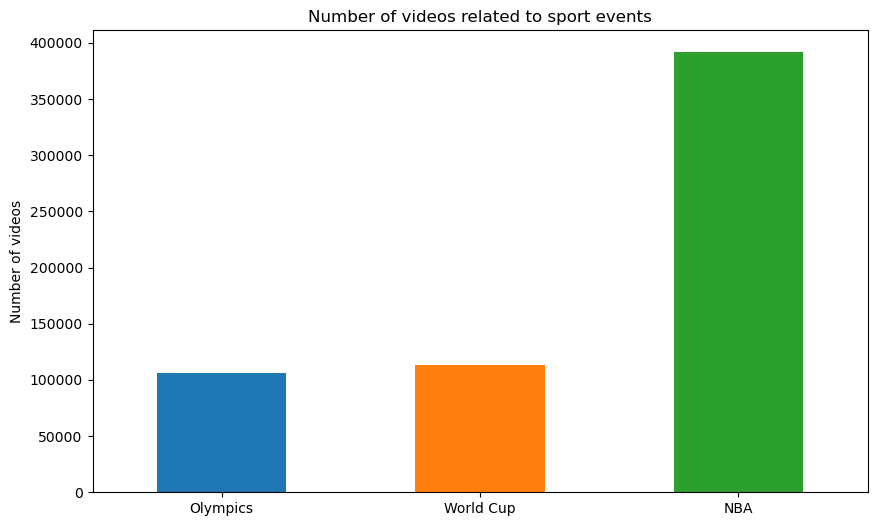

In [70]:
# Number of videos related to sport events
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_counts = pd.Series({
    "Olympics": df_olympics.shape[0],
    "World Cup": df_world_cup.shape[0],
    "NBA": df_nba.shape[0]
})
event_counts.plot(kind="bar", color=colors)
plt.title("Number of videos related to sport events")
plt.ylabel("Number of videos")
plt.xticks(rotation=0)
plt.show()

## Engagement metrics

In [64]:
df_vd_non_events = df_vd_sports[
  (~df_vd_sports["display_id"].isin(df_olympics["display_id"]))
  & (~df_vd_sports["display_id"].isin(df_world_cup["display_id"])) 
  & (~df_vd_sports["display_id"].isin(df_nba["display_id"]))
]

In [65]:
len(df_vd_non_events)

3756306

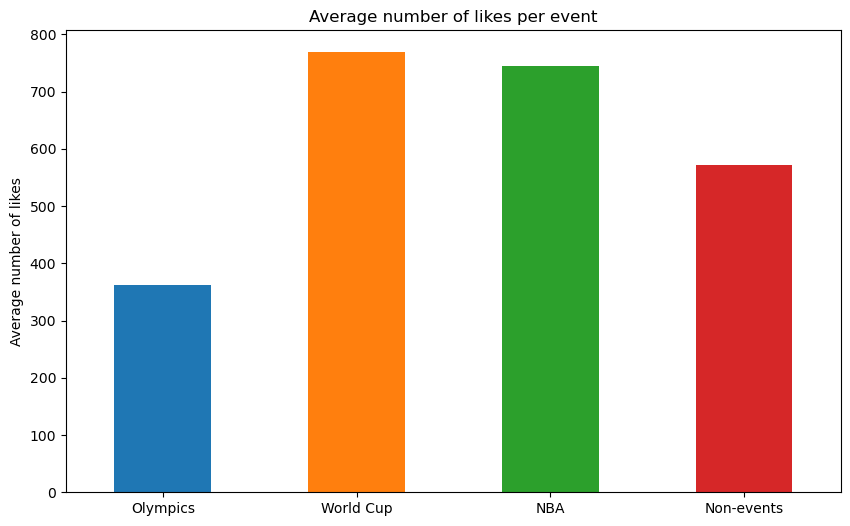

In [ ]:
# Average number of likes per event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_likes = pd.Series({
    "Olympics": df_olympics["like_count"].mean(),
    "World Cup": df_world_cup["like_count"].mean(),
    "NBA": df_nba["like_count"].mean(),
    "Non-events": df_vd_non_events["like_count"].mean()
})
event_likes.plot(kind="bar", color=colors)
plt.title("Average number of likes per event")
plt.ylabel("Average number of likes")
plt.xticks(rotation=0)
plt.show()

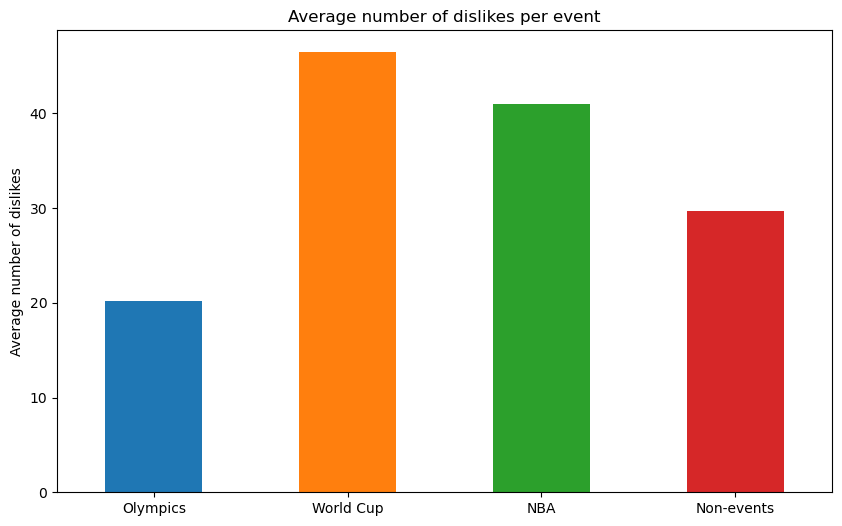

In [68]:
# Average number of dislikes per event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_dislikes = pd.Series({
    "Olympics": df_olympics["dislike_count"].mean(),
    "World Cup": df_world_cup["dislike_count"].mean(),
    "NBA": df_nba["dislike_count"].mean(),
    "Non-events": df_vd_non_events["dislike_count"].mean()
})
event_dislikes.plot(kind="bar", color=colors)
plt.title("Average number of dislikes per event")
plt.ylabel("Average number of dislikes")
plt.xticks(rotation=0)
plt.show()


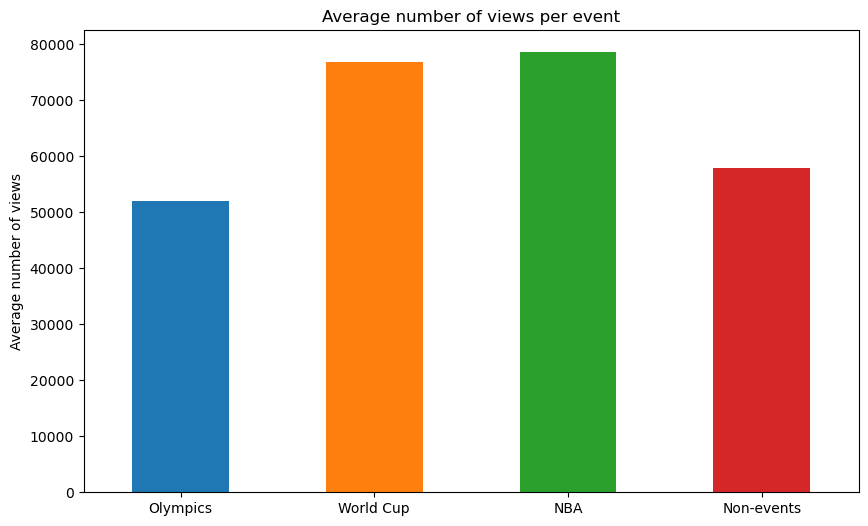

In [69]:
# Average number of views per event
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab10")
event_views = pd.Series({
    "Olympics": df_olympics["view_count"].mean(),
    "World Cup": df_world_cup["view_count"].mean(),
    "NBA": df_nba["view_count"].mean(),
    "Non-events": df_vd_non_events["view_count"].mean()
})
event_views.plot(kind="bar", color=colors)
plt.title("Average number of views per event")
plt.ylabel("Average number of views")
plt.xticks(rotation=0)
plt.show()

In [60]:
df_olympics["likes_per_view"] = df_olympics["like_count"] / df_olympics["view_count"]
df_world_cup["likes_per_view"] = df_world_cup["like_count"] / df_world_cup["view_count"]
df_nba["likes_per_view"] = df_nba["like_count"] / df_nba["view_count"]

## Sentiment analysis of titles

In [9]:
df_olympics.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,title_lower,is_related,tags_lower,description_lower
index,,,,,,,,,,,,,,,,
30366,Sports,UCzTfnC661R3LXu_mS9aRFKA,2019-11-04 11:07:21.100437,For more epic fishing action & tips check out:...,8.0,TOi8me9ijvc,55,171.0,"Matt Watson,New Zealand,Fishing,Fish,Ultimate,...",MAKO SHARK JUMPS,2018-01-17 00:00:00,19165.0,mako shark jumps,True,"[matt watson, new zealand, fishing, fish, ulti...",for more epic fishing action & tips check out:...
49077,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:42:56.211570,,0.0,VoicqeYw_KY,161,5.0,"Paralympics,Iran,London,Press TV,Nargess Mobal...",Iran's Paralympic team arrives in London,2012-08-29 00:00:00,629.0,iran's paralympic team arrives in london,True,"[paralympics, iran, london, press tv, nargess ...",
49095,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:07.484920,The organizers of the Olympic Games have been ...,1.0,-JPehFNMNio,151,11.0,"Roshan Muhammed Salih,Iran,Press TV,McDonalds,...",McDonalds dominates London's Olympic Park,2012-08-01 00:00:00,1442.0,mcdonalds dominates london's olympic park,True,"[roshan muhammed salih, iran, press tv, mcdona...",the organizers of the olympic games have been ...
49105,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:13.676141,,0.0,3-PlTZEXnPg,179,4.0,"Olympic Games,Olympics,London 2012,Amina Taylo...",Empty seats blight Olympic Games,2012-07-31 00:00:00,190.0,empty seats blight olympic games,True,"[olympic games, olympics, london 2012, amina t...",
49107,Sports,UCzSq7O3MmG-EF0Gq68uSjPw,2019-11-23 14:43:15.000911,Iran is hoping that its Olympic team in London...,1.0,M8eRQ5hiRJM,123,3.0,"Iran,Noshad Alamiyan,table tennis,ping pong,Ho...",Iran aims for Olympic success,2012-07-29 00:00:00,800.0,iran aims for olympic success,True,"[iran, noshad alamiyan, table tennis, ping pon...",iran is hoping that its olympic team in london...


In [23]:
# Faster method
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text: str) -> str:
    result = analyzer.polarity_scores(text)
    label = np.argmax([result["neg"], result["neu"], result["pos"]])
    if label == 0:
        return "negative"
    elif label == 1:
        return "neutral"
    else:
        return "positive"

In [24]:
text = "Highlight of the match between France and Germany in the 2014 World Cup."
print(analyzer.polarity_scores(text))
print(get_sentiment_label(text))

{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.34}
neutral


In [ ]:
df_olympics["title_sentiment"] = df_olympics["title"].apply(get_sentiment_label)
df_world_cup["title_sentiment"] = df_world_cup["title"].apply(get_sentiment_label)
df_nba["title_sentiment"] = df_nba["title"].apply(get_sentiment_label)

In [43]:
def plot_sentiment_distribution(df: pd.DataFrame, title: str):
    plt.figure(figsize=(6, 6))
    colors = ["#66b3ff", "#99ff99", "#ff9999"]
    sns.countplot(
        x="title_sentiment", 
        data=df, 
        order=["negative", "neutral", "positive"],
        palette=colors,
        hue="title_sentiment"
    )
    plt.xlabel("")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.title(title)
    plt.show()

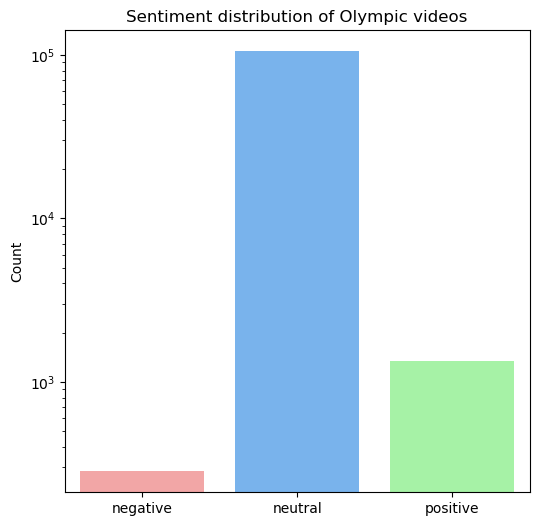

In [44]:
plot_sentiment_distribution(df_olympics, "Sentiment distribution of Olympic videos")

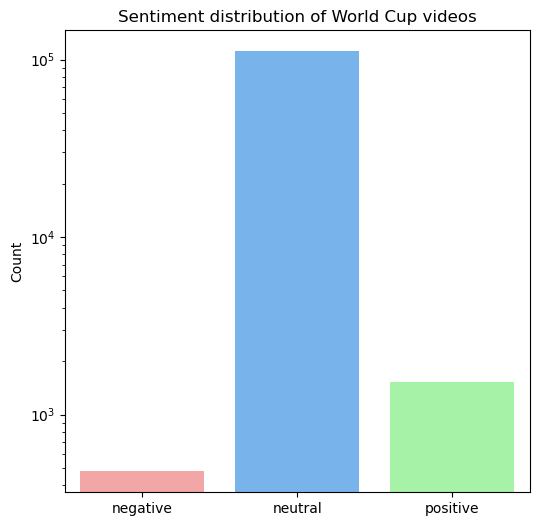

In [45]:
plot_sentiment_distribution(df_world_cup, "Sentiment distribution of World Cup videos")

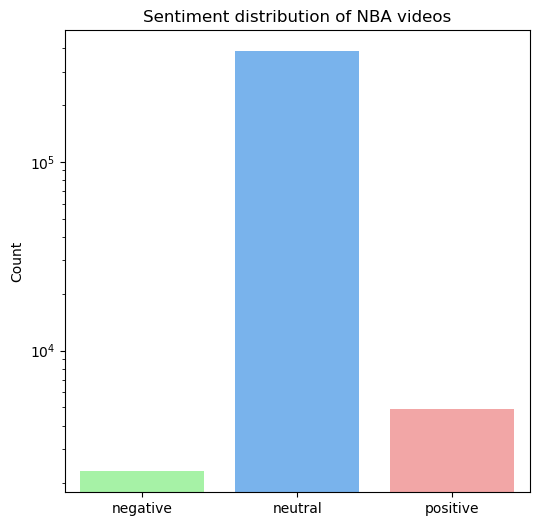

In [53]:
plot_sentiment_distribution(df_nba, "Sentiment distribution of NBA videos")

In [ ]:
# # Slower method
# from transformers import pipeline
# import torch

# if torch.backends.mps.is_available():
#     device = torch.device("mps")

# sentiment_classifier = pipeline(
#           "sentiment-analysis", 
#           model="cardiffnlp/twitter-roberta-base-sentiment",
#           device=device
# )

# def get_sentiment(text: str) -> str:
#     """
#     Get the sentiment of the text.
#     """
#     return sentiment_classifier(text)[0]["label"]

In [ ]:
# get_sentiment("Highlight of the match between France and Germany in the 2014 World Cup.")
# df_olympics["title_sentiment"] = df_olympics["title"].apply(get_sentiment)

## Difference in difference

In [18]:
df_ch_ts_olympics = pd.merge(df_ts_f, df_olympics, left_on="channel",  right_on="channel_id", how="inner")

Missing values
 delta_views                     0
is_sports                       0
Rio_de_jainero_olympics_2016    0
interaction                     0
dtype: int64


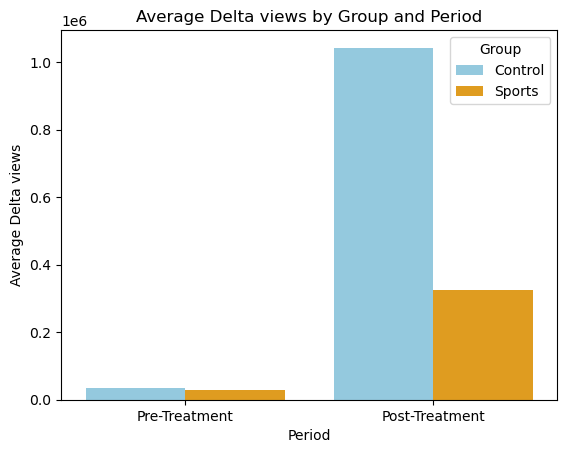

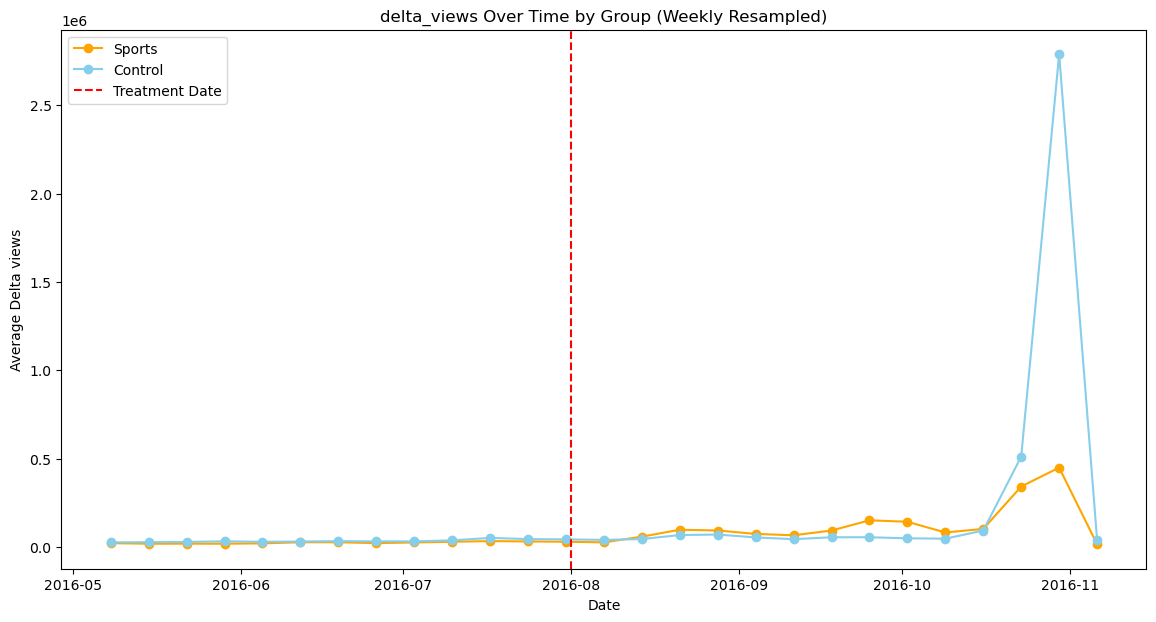

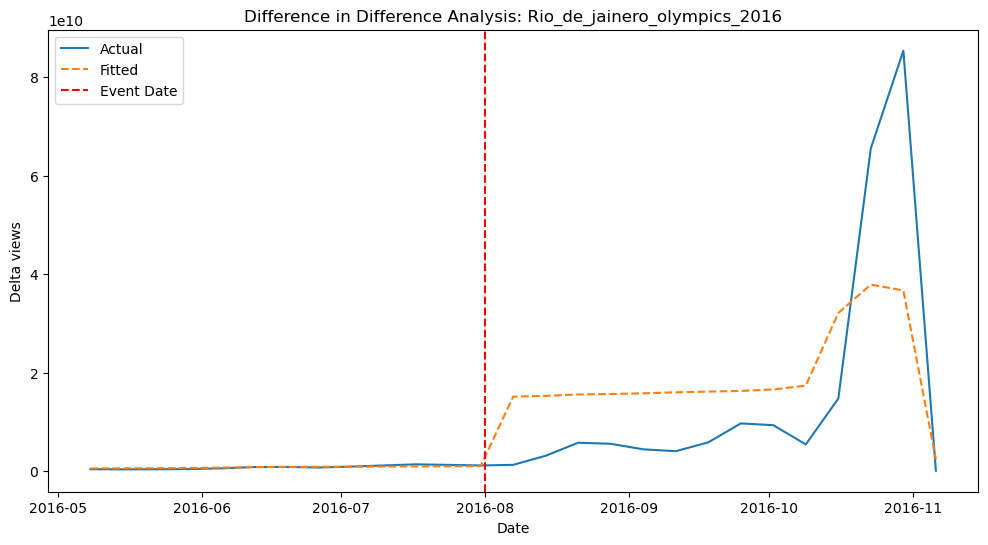

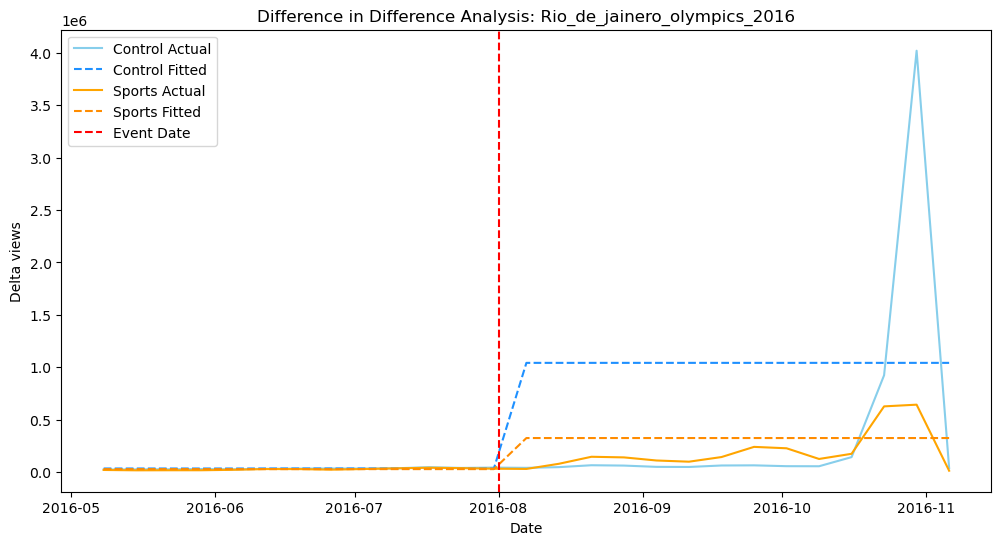

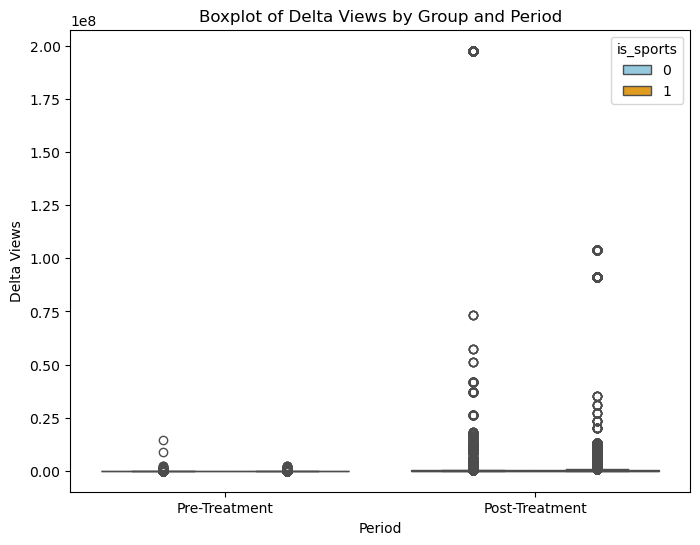

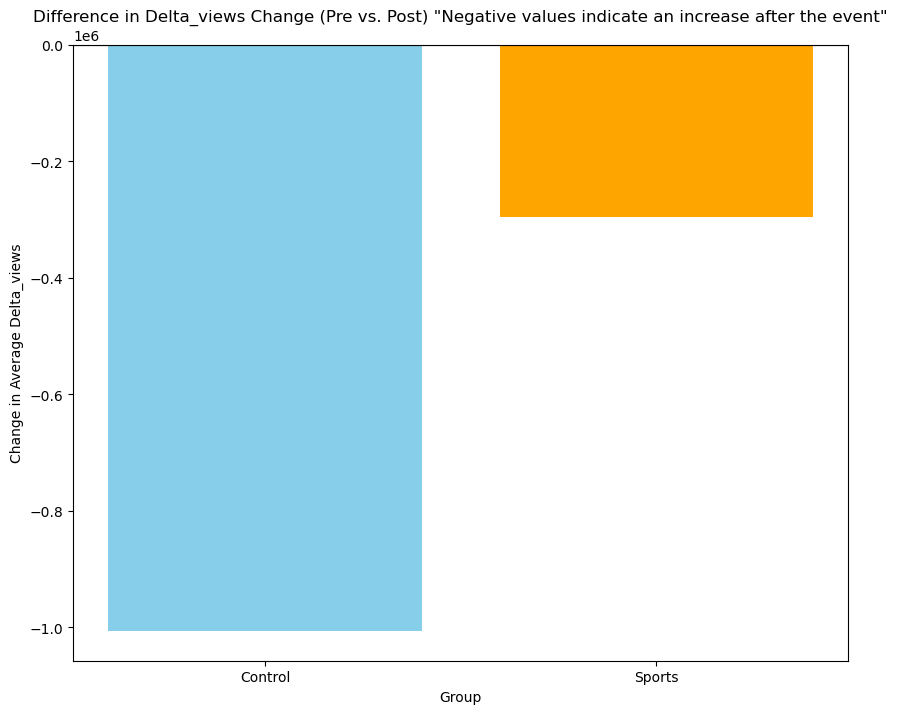

                            OLS Regression Results                            
Dep. Variable:            delta_views   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1974.
Date:                Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:43:49   Log-Likelihood:            -1.8944e+07
No. Observations:             1156918   AIC:                         3.789e+07
Df Residuals:                 1156914   BIC:                         3.789e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [20]:
diff_in_diff(df_ch_ts_olympics, "datetime", "delta_views", pd.to_datetime('2016-08'), 'Rio_de_jainero_olympics_2016', 3)

# Part 3: Sport-based analysis

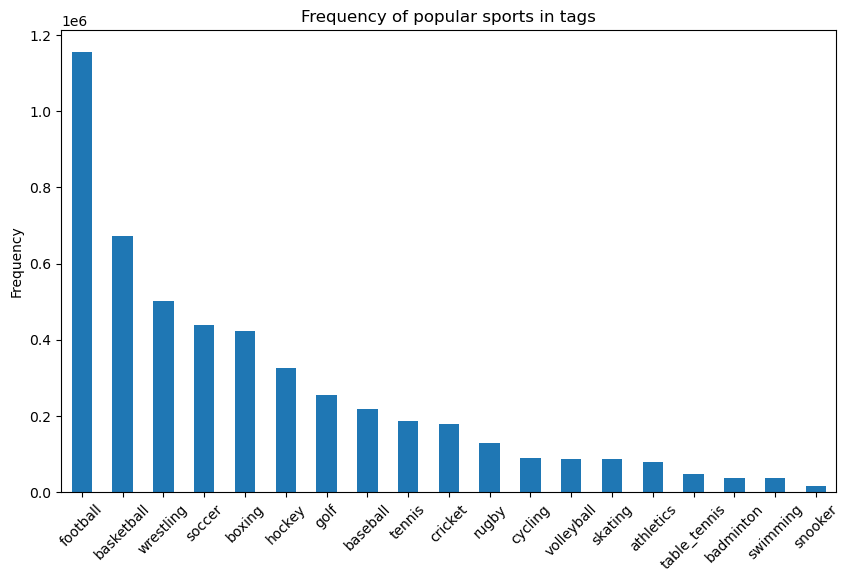

In [82]:
# Frequency of sports in tags
tag_counts = Counter(all_tags_sport)

popular_sports = ["soccer", "football", "cricket", "hockey", 
          "tennis", "volleyball", "baseball", "rugby", 
          "golf", "snooker", "basketball", "skating",
          "swimming", "wrestling", "table_tennis", "badminton",
          "cycling", "boxing", "athletics"
          ]

popular_sports_counts = {sport: tag_counts[sport] for sport in popular_sports}

plt.figure(figsize=(10, 6))
popular_sports_counts_series = pd.Series(popular_sports_counts)
popular_sports_counts_series.sort_values(ascending=False).plot(kind="bar")
plt.title("Frequency of popular sports in tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Part 4: User engagement